In [78]:
import os

In [80]:
patients_to_analyze = ['pat'+str(i) for i in range(1, 10)]

per_patient_state = {
    
    'pat1': { 'sleep': 2602, 'wake': 7009},
    
    'pat2': { 'sleep': 1664, 'wake': 1709},
    
    'pat3': { 'sleep': 711, 'wake':1283},
    
    'pat4': { 'sleep': 11269, 'wake':486},
#     'pat5': { 'wake': 2659, 'sleep': 753},
    'pat5': { 'wake': 2722, 'sleep': 765}, 
#     'pat6' : {'wake': 287, 'sleep': 796},
    'pat6' : {'wake': 289, 'sleep': 819},
#     'pat7' : {'wake': 1421, 'sleep': 2194},
    'pat7' : {'wake': 1533, 'sleep': 2235},
#     'pat8' : {'wake': 354, 'sleep': 1849},
    'pat8' : {'wake': 356, 'sleep': 1997},
#     'pat9' : {'wake': 522, 'sleep': 644},
    'pat9' : {'wake': 530, 'sleep': 652},
#     'pat10' : {'wake': 4979}
    'pat10' : {'wake': 5084, 'sleep': 5728}
}


# Distribution of number of causal interactions for different windows

In [3]:
import json
import matplotlib.pyplot as plt
path100 = '/home/garkots/invasive_eeg/analysis/results/experiment_window_100/'
path500 = '/home/garkots/invasive_eeg/analysis/results/experiment_window_500/'

In [13]:
dct= { 'pat10' : {
            'wake': {'path_edf' : '/data/garkots/third_package/pat10_wake/EEG_1222-export.edf',
                      'path_ann' : '/data/garkots/third_package/pat10_wake/',
                      'path_visual' : '/home/garkots/invasive_eeg/analysis/visuals/component_choice/experiment_window_100/pat10/wake',
                      'path_results' : '/home/garkots/invasive_eeg/analysis/visuals/component_choice/experiment_window_100/pat10/wake',
                      'path_ica' : '/home/garkots/invasive_eeg/analysis/matrices_ica/pat10/wake',
                      'chosen_components' : ['ICA010',  'ICA005', 'ICA001']
                      },
             'sleep':{'path_edf' : '/data/garkots/third_package/pat10_sleep/EEG_1221-export.edf',
                      'path_ann' : '/data/garkots/third_package/pat10_sleep/',
                      'path_visual' : '/home/garkots/invasive_eeg/analysis/visuals/component_choice/experiment_window_100/pat10/sleep',
                      'path_results' : '/home/garkots/invasive_eeg/analysis/visuals/component_choice/experiment_window_100/pat10/sleep',
                      'path_ica' : '/home/garkots/invasive_eeg/analysis/matrices_ica/pat10/sleep',
                      'chosen_components' : ['ICA009', 'ICA005', 'ICA008']
                      }
             }}

In [19]:
from patient import Patient
p, s = 'pat10', 'wake'
patient = Patient(edf_file = dct[p][s]['path_edf'],
                 annotations =  dct[p][s]['path_ann'],
                 path_to_visual_outputs= dct[p][s]['path_visual'],
                 path_to_results= dct[p][s]['path_results'],
                 path_to_ica_matrix= dct[p][s]['path_ica'],
                 precomputed_ica = True,
                 ignore_channels = True,
                 window_length = 500,
                 chosen_components =dct[p][s]['chosen_components'],
                 control_experiment = False)

patient.quantify_annotations()
patient.run_ica()
patient.no_channels_during_seizures_states()
patient.normalize_components()
chosen = patient.chosen_components
patient.get_significant_components_state(potentially_significant=chosen)


CHOSEN COMPONENTS ['ICA010', 'ICA005', 'ICA001']
Extracting EDF parameters from /data/garkots/third_package/pat10_wake/EEG_1222-export.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/home/garkots/invasive_eeg/analysis/scripts/patient.py:39: RuntimeWarning: Number of records from the header does not match the file size (perhaps the recording was not stopped before exiting). Inferring from the file size.
  self.raw = mne.io.read_raw_edf(edf_file)


Channel  PAT10_WAKE_EEG_1222 with  5059 markings
Total number of markings 5059


In [37]:
per_component_states = patient.per_component_state_during_seizures

In [20]:
def get_average(arrays):
    # arrays --> list of lists, where every list is a cropped IED on a Signal

    result = []
    stdevs = []

    # iterating over every count
    for enrty_indx in range(len(arrays[0])):

        # we will record average summing the corresponding counts
        to_get_average = []

        # iterating over every component
        for i in range(len(arrays)):
            # get the state
            state = arrays[i]

            to_get_average.append(state[enrty_indx])

        result.append(sum(to_get_average) / len(to_get_average))
        stdevs.append(np.std(to_get_average))

    return np.array(result), np.array(stdevs)

In [23]:
import numpy as np

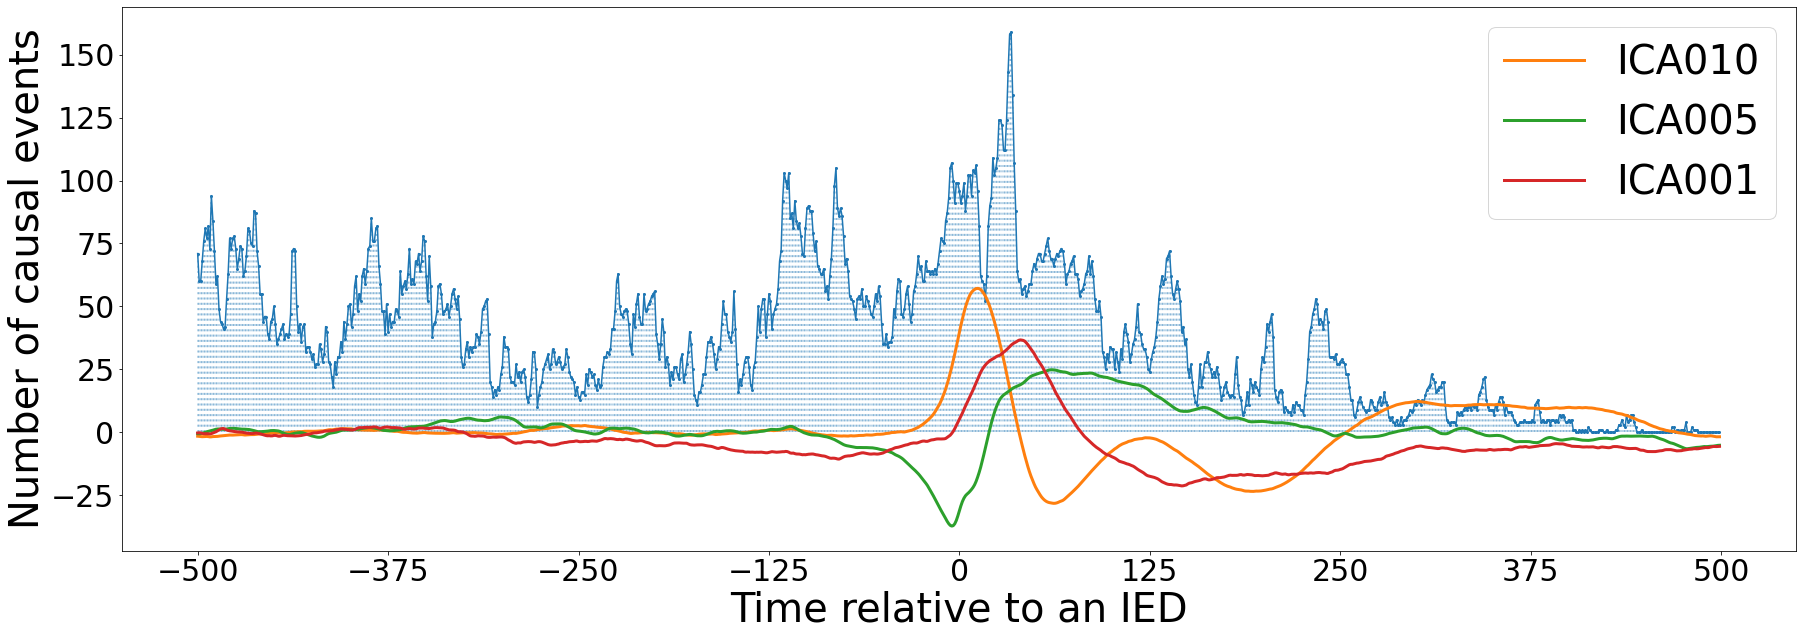

In [50]:
def hist_plot(path, pat, state, per_component_states, w=500):
    for file in os.listdir(path+pat+'/'+state):
        if not ("total" in file and ".json" in file):  # removing the results for most frequent tau, cause I recorded for both most frequent and all the taus 
            continue
        filename = path+pat+'/'+state+'/'+file
        f = open(filename, 'r')
        data = json.load(f)
        f.close()
        
#         duration_timestamp = [i - self.window_to_detect for i in range(len(average_signal))]
        
        
        timestamps = [int(i) for i in data.keys()]
        values = [data[str(i)] for i in timestamps]
        plt.figure(figsize=(30, 10))
                   
        for t,v in zip(timestamps, values):
            plt.vlines(x=t, ymin=0, ymax=v,  ls=':', lw=2, alpha=0.3)
        
         
        plt.plot(timestamps, values,  marker='o', markersize=2)
        
        
    for component in dct[pat][state]['chosen_components']:
        average_component, component_stdev = get_average(per_component_states[component])

        plt.plot(timestamps, 100*average_component, lw=3, label=component)

    plt.xticks(ticks=[i for i in range(-w, w+1, w//4)], fontsize=30)
    plt.yticks( fontsize=30)
    plt.xlabel('Time relative to an IED', fontsize=40)
    plt.ylabel('Number of causal events', fontsize=40)
    plt.legend(prop={'size': 40})
    plt.show()
        
hist_plot(path500, 'pat10', 'wake', per_component_states=per_component_states)  

In [51]:
from patient import Patient
p, s = 'pat10', 'wake'
patient = Patient(edf_file = dct[p][s]['path_edf'],
                 annotations =  dct[p][s]['path_ann'],
                 path_to_visual_outputs= dct[p][s]['path_visual'],
                 path_to_results= dct[p][s]['path_results'],
                 path_to_ica_matrix= dct[p][s]['path_ica'],
                 precomputed_ica = True,
                 ignore_channels = True,
                 window_length = 100,
                 chosen_components =dct[p][s]['chosen_components'],
                 control_experiment = False)

patient.quantify_annotations()
patient.run_ica()
patient.no_channels_during_seizures_states()
patient.normalize_components()
chosen = patient.chosen_components
patient.get_significant_components_state(potentially_significant=chosen)

        

CHOSEN COMPONENTS ['ICA010', 'ICA005', 'ICA001']
Extracting EDF parameters from /data/garkots/third_package/pat10_wake/EEG_1222-export.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/home/garkots/invasive_eeg/analysis/scripts/patient.py:39: RuntimeWarning: Number of records from the header does not match the file size (perhaps the recording was not stopped before exiting). Inferring from the file size.
  self.raw = mne.io.read_raw_edf(edf_file)


Channel  PAT10_WAKE_EEG_1222 with  5059 markings
Total number of markings 5059


In [52]:
per_component_states = patient.per_component_state_during_seizures

In [53]:
def get_average(arrays):
    # arrays --> list of lists, where every list is a cropped IED on a Signal

    result = []
    stdevs = []

    # iterating over every count
    for enrty_indx in range(len(arrays[0])):

        # we will record average summing the corresponding counts
        to_get_average = []

        # iterating over every component
        for i in range(len(arrays)):
            # get the state
            state = arrays[i]

            to_get_average.append(state[enrty_indx])

        result.append(sum(to_get_average) / len(to_get_average))
        stdevs.append(np.std(to_get_average))

    return np.array(result), np.array(stdevs)

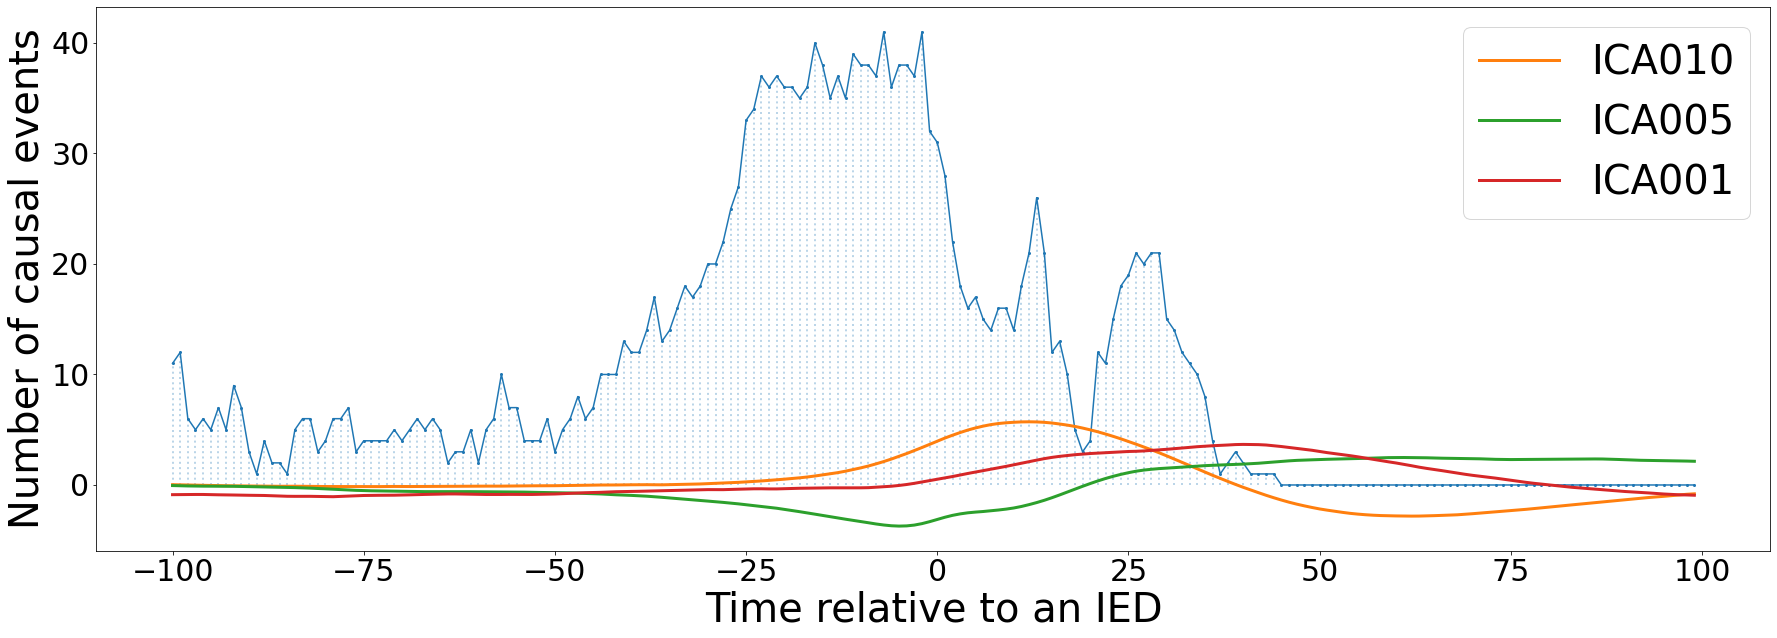

In [56]:
def hist_plot(path, pat, state, per_component_states, w=500):
    for file in os.listdir(path+pat+'/'+state):
        if not ("total" in file and ".json" in file):  # removing the results for most frequent tau, cause I recorded for both most frequent and all the taus 
            continue
        filename = path+pat+'/'+state+'/'+file
        f = open(filename, 'r')
        data = json.load(f)
        f.close()
        
#         duration_timestamp = [i - self.window_to_detect for i in range(len(average_signal))]
        
        
        timestamps = [int(i) for i in data.keys()]
        values = [data[str(i)] for i in timestamps]
        plt.figure(figsize=(30, 10))
                   
        for t,v in zip(timestamps, values):
            plt.vlines(x=t, ymin=0, ymax=v,  ls=':', lw=2, alpha=0.3)
        
         
        plt.plot(timestamps, values,  marker='o', markersize=2)
        
        
    for component in dct[pat][state]['chosen_components']:
        average_component, component_stdev = get_average(per_component_states[component])

        plt.plot(timestamps, 10*average_component, lw=3, label=component)

    plt.xticks(ticks=[i for i in range(-w, w+1, w//4)], fontsize=30)
    plt.yticks( fontsize=30)
    plt.xlabel('Time relative to an IED', fontsize=40)
    plt.ylabel('Number of causal events', fontsize=40)
    plt.legend(prop={'size': 40})
    plt.show()
        
hist_plot(path100, 'pat10', 'wake', per_component_states=per_component_states, w=100)  

CHOSEN COMPONENTS ['ICA009', 'ICA005', 'ICA008']
Extracting EDF parameters from /data/garkots/third_package/pat10_sleep/EEG_1221-export.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Channel  PAT10_SLEEP_EEG_1221 with  5728 markings
Total number of markings 5727


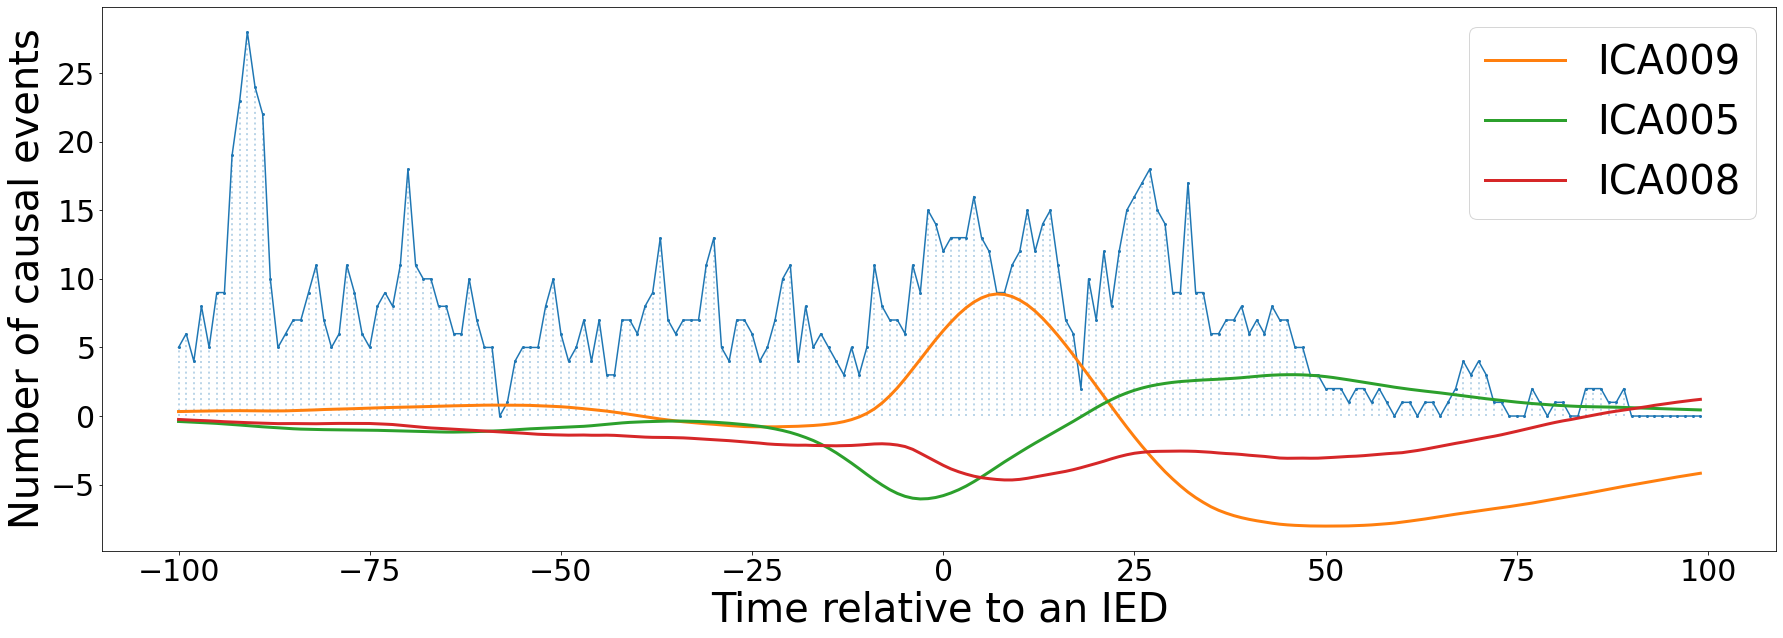

In [73]:
from patient import Patient
p, s = 'pat10', 'sleep'
patient = Patient(edf_file = dct[p][s]['path_edf'],
                 annotations =  dct[p][s]['path_ann'],
                 path_to_visual_outputs= dct[p][s]['path_visual'],
                 path_to_results= dct[p][s]['path_results'],
                 path_to_ica_matrix= dct[p][s]['path_ica'],
                 precomputed_ica = True,
                 ignore_channels = True,
                 window_length = 100,
                 chosen_components =dct[p][s]['chosen_components'],
                 control_experiment = False)

patient.quantify_annotations()
patient.run_ica()
patient.no_channels_during_seizures_states()
patient.normalize_components()
chosen = patient.chosen_components
patient.get_significant_components_state(potentially_significant=chosen)
per_component_states = patient.per_component_state_during_seizures

hist_plot(path100, 'pat10', 'sleep', per_component_states=per_component_states, w=100)  

In [ ]:
p, s = 'pat10', 'sleep'
patient = Patient(edf_file = dct[p][s]['path_edf'],
                 annotations =  dct[p][s]['path_ann'],
                 path_to_visual_outputs= dct[p][s]['path_visual'],
                 path_to_results= dct[p][s]['path_results'],
                 path_to_ica_matrix= dct[p][s]['path_ica'],
                 precomputed_ica = True,
                 ignore_channels = True,
                 window_length = 500,
                 chosen_components =dct[p][s]['chosen_components'],
                 control_experiment = False)

patient.quantify_annotations()
patient.run_ica()
patient.no_channels_during_seizures_states()
patient.normalize_components()
chosen = patient.chosen_components
patient.get_significant_components_state(potentially_significant=chosen)
per_component_states = patient.per_component_state_during_seizures


hist_plot(path500, 'pat10', 'sleep', per_component_states=per_component_states,  w=500)

# _______

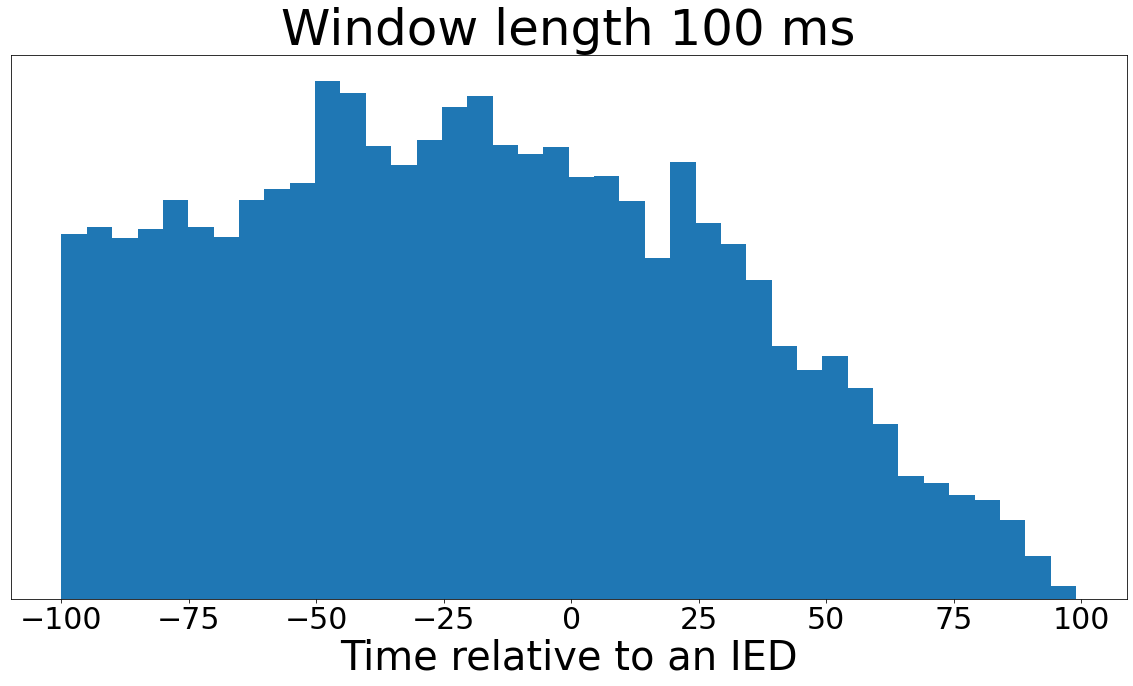

In [45]:
def total_n_o_components(path, w=100):
    total_events = []
    for pat in per_patient_state:
        for state in per_patient_state[pat]:

            for file in os.listdir(path+pat+'/'+state):
                if not ("total" in file and ".json" in file):  # removing the results for most frequent tau, cause I recorded for both most frequent and all the taus 
                    continue
                filename = path+pat+'/'+state+'/'+file
                f = open(filename, 'r')
                data = json.load(f)
                f.close()

                for k in data:
                    for j in range(data[k]):
                        total_events.append(int(k))


    plt.figure(figsize=(20, 10))
    plt.hist(total_events, bins=40)
    plt.xlabel('Time relative to an IED', fontsize=40)
#     plt.ylabel('№ of causal events detected', fontsize=40) 
    plt.yticks(ticks=[])
    plt.xticks(ticks=[i for i in range(-w, w+1, w//4)], fontsize=30)
    plt.title(f'Window length {w} ms', fontsize=50)
    plt.show()
    
total_n_o_components(path100)  

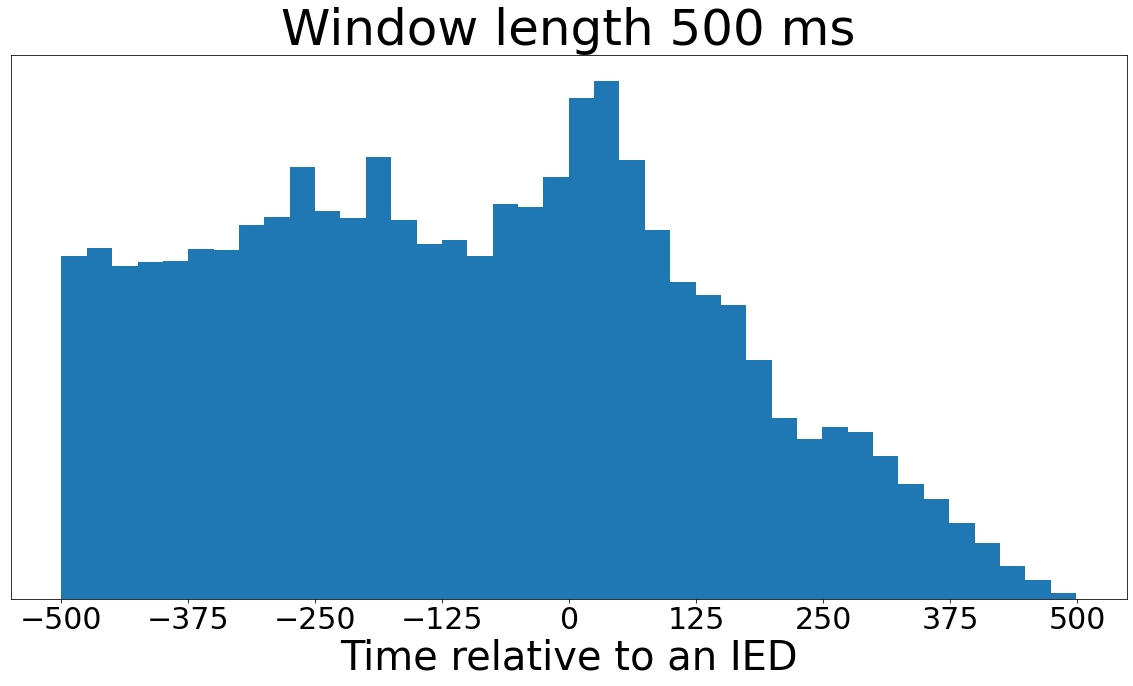

In [46]:
total_n_o_components(path500, w=500)

# Normalized number of causal interactions

In [106]:
# a) 
patients_to_analyze = ['pat'+str(i) for i in range(1,11)]

per_patient_state = {
    
    'pat1': { 'sleep': 2602, 'wake': 7009},
    
    'pat2': { 'sleep': 1664, 'wake': 1709},
    
    'pat3': { 'sleep': 711, 'wake':1283},
    
    'pat4': { 'sleep': 11269, 'wake':486},
#     'pat5': { 'wake': 2659, 'sleep': 753},
    'pat5': { 'wake': 2722, 'sleep': 765}, 
#     'pat6' : {'wake': 287, 'sleep': 796},
    'pat6' : {'wake': 289, 'sleep': 819},
#     'pat7' : {'wake': 1421, 'sleep': 2194},
    'pat7' : {'wake': 1533, 'sleep': 2235},
#     'pat8' : {'wake': 354, 'sleep': 1849},
    'pat8' : {'wake': 356, 'sleep': 1997},
#     'pat9' : {'wake': 522, 'sleep': 644},
    'pat9' : {'wake': 530, 'sleep': 652},
#     'pat10' : {'wake': 4979}
    'pat10' : {'wake': 5084, 'sleep': 5728}
}
number_of_interactions_total, number_of_interactions_wake, number_of_interactions_sleep = {}, {}, {}

for pat in per_patient_state:
    for state in per_patient_state[pat]:

        for file in os.listdir(path100+pat+'/'+state):
            
            if not ("total" in file and ".json" in file):  # removing the results for most frequent tau, cause I recorded for both most frequent and all the taus 
                continue
            
            filename = path100+pat+'/'+state+'/'+file
            f = open(filename, 'r')
            data = json.load(f)
            f.close()

        
            for k in data:

                if 'wake' in file :

                    if int(k) in number_of_interactions_wake.keys():
                        number_of_interactions_wake[int(k)].append(int(data[k]))
                    else:
                        number_of_interactions_wake[int(k)] = [int(data[k])]

                elif 'sleep' in file:

                    if int(k) in number_of_interactions_sleep.keys():
                        number_of_interactions_sleep[int(k)].append(int(data[k]))
                    else:
                        number_of_interactions_sleep[int(k)] = [int(data[k])]

                if int(k) in number_of_interactions_total.keys():
                        number_of_interactions_total[int(k)].append(int(data[k])/per_patient_state[pat][state])
                else:
                    number_of_interactions_total[int(k)] = [int(data[k])/per_patient_state[pat][state]]

for k in number_of_interactions_total:
    number_of_interactions_total[k] = sum(number_of_interactions_total[k])/len(number_of_interactions_total[k])
    
for k in number_of_interactions_sleep:
    number_of_interactions_sleep[k] = sum(number_of_interactions_sleep[k])/len(number_of_interactions_sleep[k])
    
for k in number_of_interactions_wake:
    number_of_interactions_wake[k] = sum(number_of_interactions_wake[k])/len(number_of_interactions_wake[k])
    
average_wake, average_sleep, average_total = [], [], []

for k in number_of_interactions_wake:
#     print('k', k, 'number_of_interactions_wake[k]', number_of_interactions_wake[k])
    for i in range(int(number_of_interactions_wake[k])):
        average_wake.append(k)

for k in number_of_interactions_sleep:
#     print('k', k, 'number_of_interactions_sleep[k]', number_of_interactions_sleep[k])
    for i in range(int(number_of_interactions_sleep[k])):
        average_sleep.append(k)
        
        
for k in number_of_interactions_total:
#     print('k', k, 'number_of_interactions_total[k]', number_of_interactions_total[k])
    for i in range(int(number_of_interactions_total[k])):
        average_total.append(k)

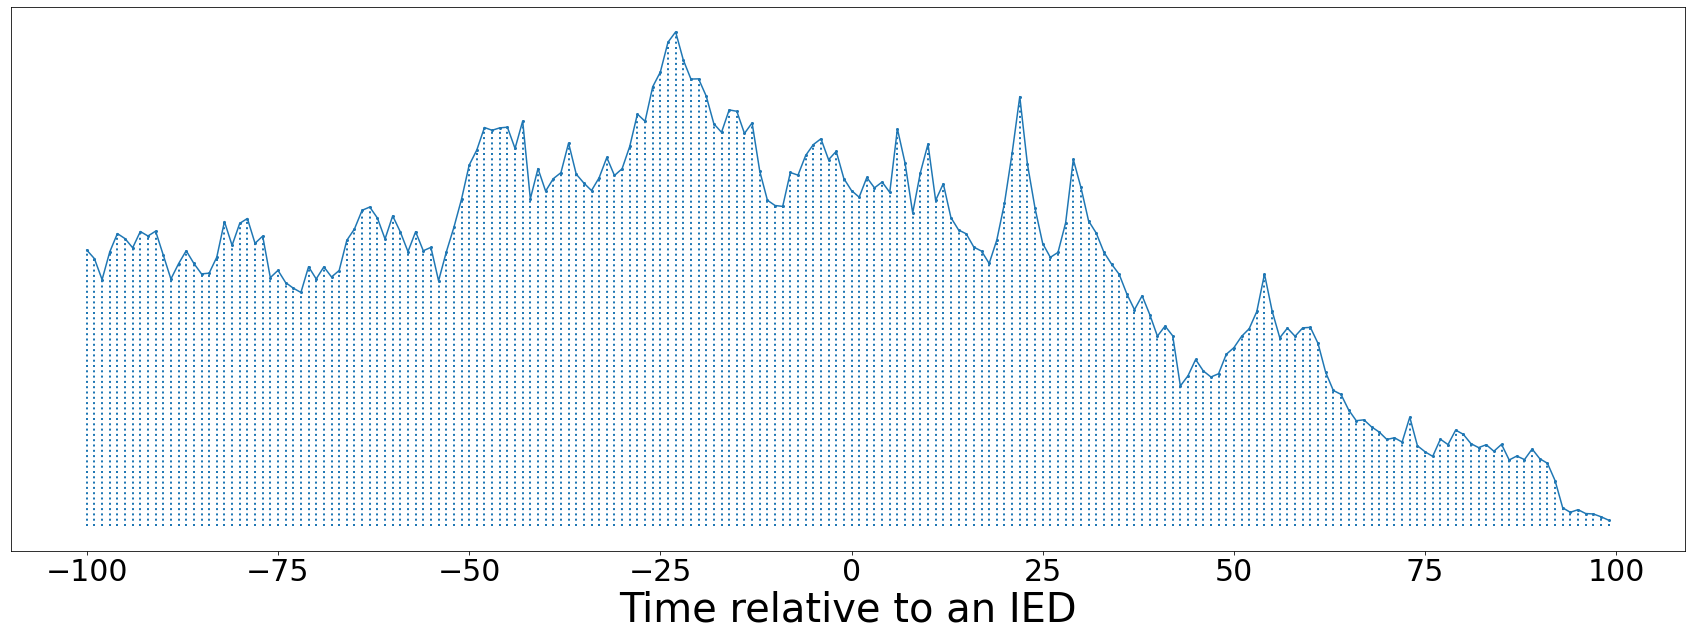

In [107]:
w=100
timestamps100 = [int(i) for i in number_of_interactions_total.keys()]
values100 = [number_of_interactions_total[i] for i in number_of_interactions_total]
plt.figure(figsize=(30, 10))

for t,v in zip(timestamps100, values100):
    plt.vlines(x=t, ymin=0, ymax=v,  ls=':', lw=2)
plt.plot(timestamps100, values100,  marker='o', markersize=2)
plt.xlabel('Time relative to an IED', fontsize=40)
#     plt.ylabel('№ of causal events detected', fontsize=40) 
plt.yticks(ticks=[])
plt.xticks(ticks=[i for i in range(-w, w+1, w//4)], fontsize=30)
plt.show()

In [103]:
# a) 
patients_to_analyze = ['pat'+str(i) for i in range(1,11)]

per_patient_state = {
    
    'pat1': { 'sleep': 2602, 'wake': 7009},
    
    'pat2': { 'sleep': 1664, 'wake': 1709},
    
    'pat3': { 'sleep': 711, 'wake':1283},
    
    'pat4': { 'sleep': 11269, 'wake':486},
#     'pat5': { 'wake': 2659, 'sleep': 753},
    'pat5': { 'wake': 2722, 'sleep': 765}, 
#     'pat6' : {'wake': 287, 'sleep': 796},
    'pat6' : {'wake': 289, 'sleep': 819},
#     'pat7' : {'wake': 1421, 'sleep': 2194},
    'pat7' : {'wake': 1533, 'sleep': 2235},
#     'pat8' : {'wake': 354, 'sleep': 1849},
    'pat8' : {'wake': 356, 'sleep': 1997},
#     'pat9' : {'wake': 522, 'sleep': 644},
    'pat9' : {'wake': 530, 'sleep': 652},
#     'pat10' : {'wake': 4979}
    'pat10' : {'wake': 5084, 'sleep': 5728}
}
number_of_interactions_total, number_of_interactions_wake, number_of_interactions_sleep = {}, {}, {}

for pat in per_patient_state:
    for state in per_patient_state[pat]:

        for file in os.listdir(path500+pat+'/'+state):
            
            if not ("total" in file and ".json" in file):  # removing the results for most frequent tau, cause I recorded for both most frequent and all the taus 
                continue
            
            filename = path500+pat+'/'+state+'/'+file
            f = open(filename, 'r')
            data = json.load(f)
            f.close()

        
            for k in data:

                if 'wake' in file :

                    if int(k) in number_of_interactions_wake.keys():
                        number_of_interactions_wake[int(k)].append(int(data[k]))
                    else:
                        number_of_interactions_wake[int(k)] = [int(data[k])]

                elif 'sleep' in file:

                    if int(k) in number_of_interactions_sleep.keys():
                        number_of_interactions_sleep[int(k)].append(int(data[k]))
                    else:
                        number_of_interactions_sleep[int(k)] = [int(data[k])]

                if int(k) in number_of_interactions_total.keys():
                        number_of_interactions_total[int(k)].append(int(data[k])/per_patient_state[pat][state])
                else:
                    number_of_interactions_total[int(k)] = [int(data[k])/per_patient_state[pat][state]]

for k in number_of_interactions_total:
    number_of_interactions_total[k] = sum(number_of_interactions_total[k])/len(number_of_interactions_total[k])
    
for k in number_of_interactions_sleep:
    number_of_interactions_sleep[k] = sum(number_of_interactions_sleep[k])/len(number_of_interactions_sleep[k])
    
for k in number_of_interactions_wake:
    number_of_interactions_wake[k] = sum(number_of_interactions_wake[k])/len(number_of_interactions_wake[k])
    
average_wake, average_sleep, average_total = [], [], []

for k in number_of_interactions_wake:
#     print('k', k, 'number_of_interactions_wake[k]', number_of_interactions_wake[k])
    for i in range(int(number_of_interactions_wake[k])):
        average_wake.append(k)

for k in number_of_interactions_sleep:
#     print('k', k, 'number_of_interactions_sleep[k]', number_of_interactions_sleep[k])
    for i in range(int(number_of_interactions_sleep[k])):
        average_sleep.append(k)
        
        
for k in number_of_interactions_total:
#     print('k', k, 'number_of_interactions_total[k]', number_of_interactions_total[k])
    for i in range(int(number_of_interactions_total[k])):
        average_total.append(k)

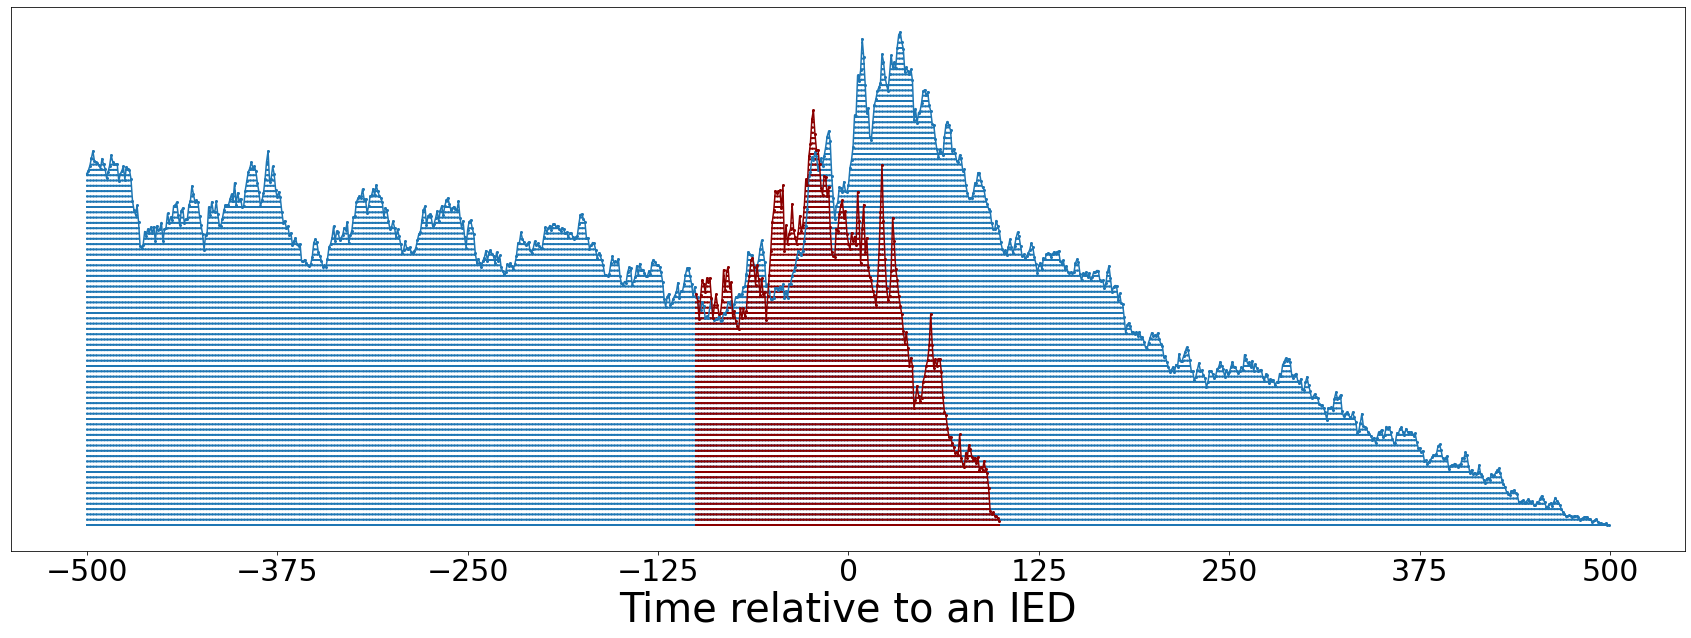

In [104]:
timestamps = [int(i) for i in number_of_interactions_total.keys()]
values = [number_of_interactions_total[i] for i in number_of_interactions_total]
plt.figure(figsize=(30, 10))

for t,v in zip(timestamps, values):
    plt.vlines(x=t, ymin=0, ymax=v,  ls=':', lw=2)
plt.plot(timestamps, values,  marker='o', markersize=2)
plt.xlabel('Time relative to an IED', fontsize=40)

for t,v in zip(timestamps100, values100):
    plt.vlines(x=t, ymin=0, ymax=v,  ls=':', lw=2, color='darkred')
plt.plot(timestamps100, values100,  marker='o', markersize=2, color='darkred')
#     plt.ylabel('№ of causal events detected', fontsize=40) 
plt.yticks(ticks=[])
plt.xticks(ticks=[i for i in range(-w, w+1, w//4)], fontsize=30)
plt.show()

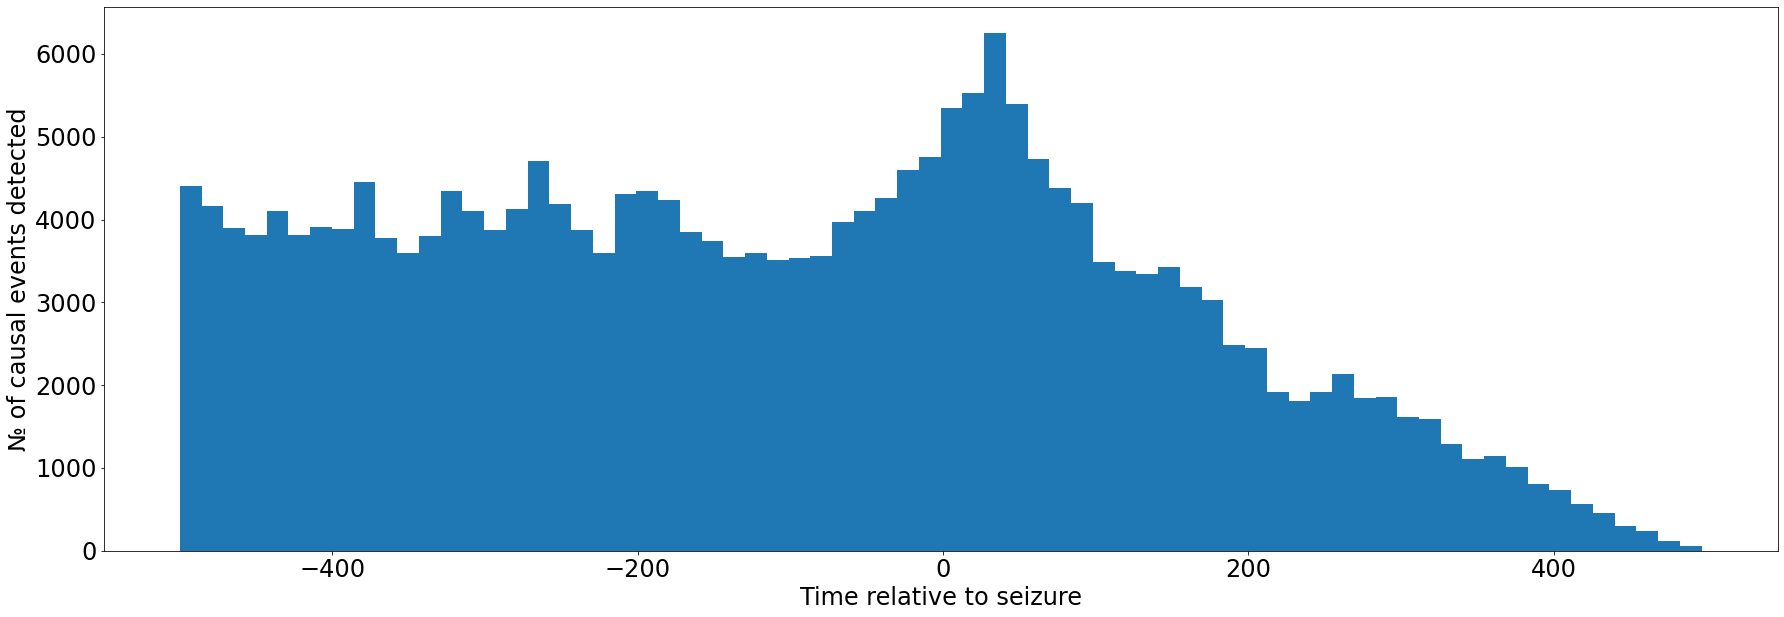

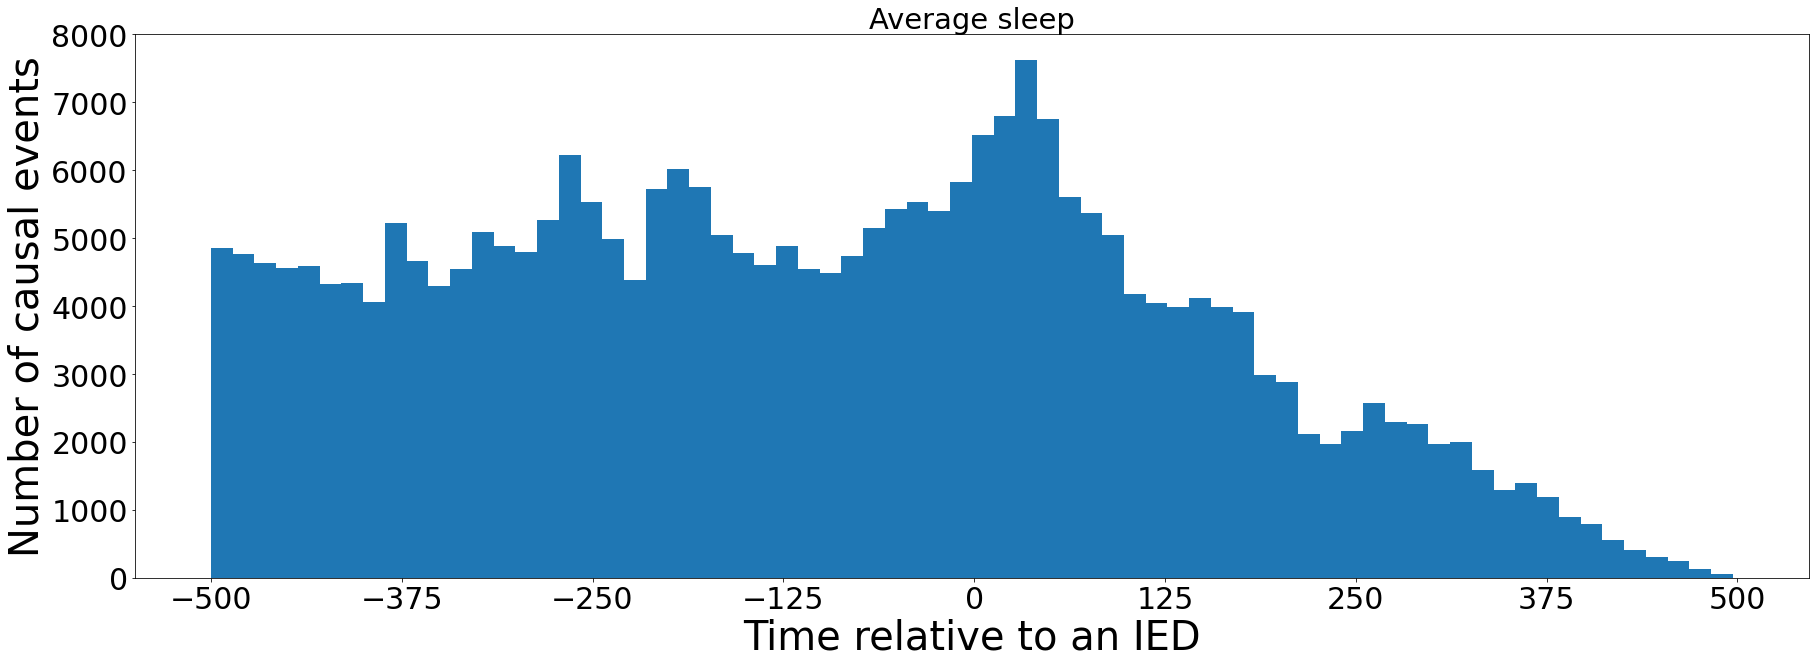

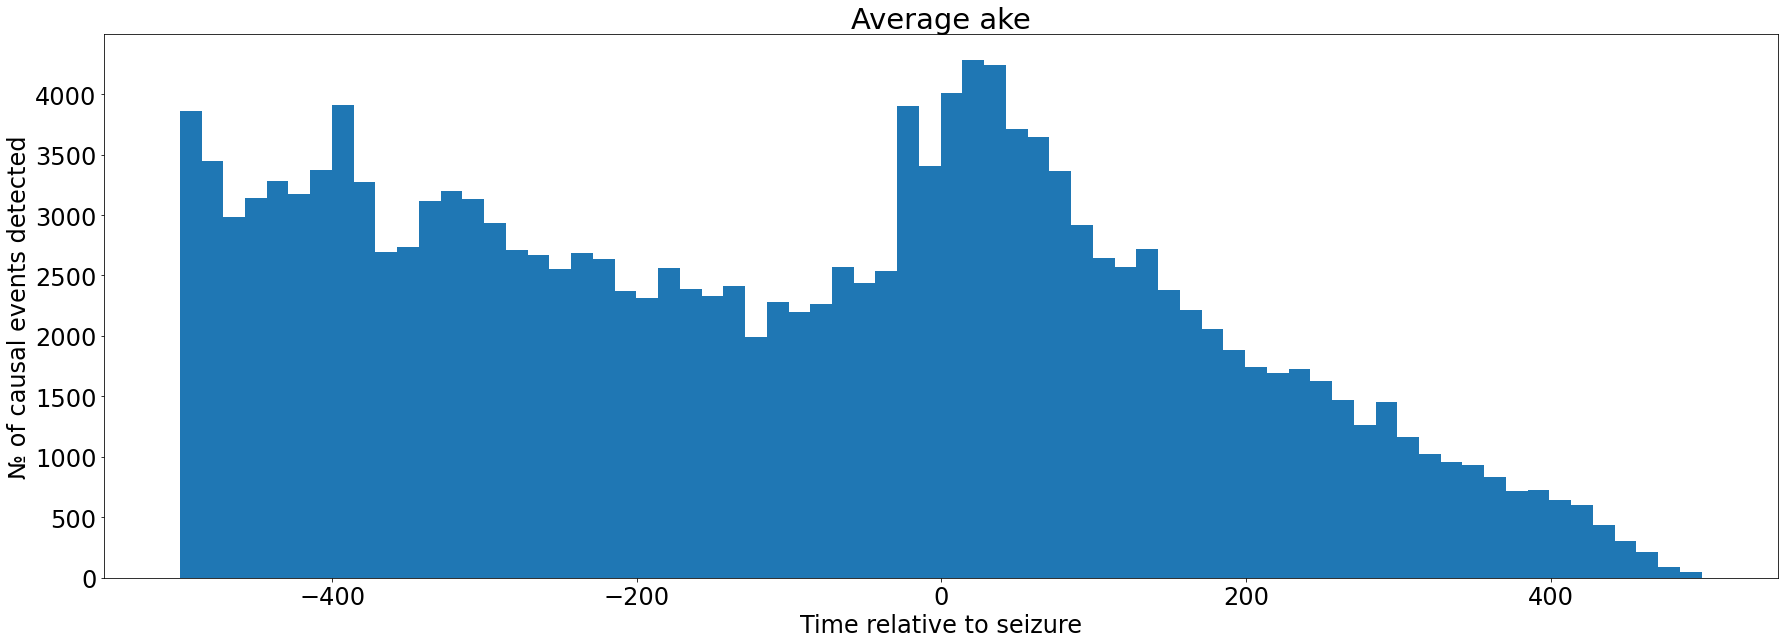

In [77]:
w=500
plt.figure(figsize=(30, 10))
plt.hist(average_total, bins=70)
plt.xlabel('Time relative to seizure', fontsize=24)
plt.ylabel('№ of causal events detected', fontsize=24) 
plt.yticks(fontsize=24)
plt.xticks(fontsize=24)
# plt.title('Average sleep+wake', fontsize=29)
plt.show()
    
        
plt.figure(figsize=(30, 10))
plt.hist(average_sleep, bins=70)
plt.title('Average sleep', fontsize=29)
plt.xticks(ticks=[i for i in range(-w, w+1, w//4)], fontsize=30)
plt.yticks( fontsize=30)
plt.xlabel('Time relative to an IED', fontsize=40)
plt.ylabel('Number of causal events', fontsize=40)
# plt.legend(prop={'size': 40})
plt.show()

        
plt.figure(figsize=(30, 10))
plt.hist(average_wake, bins=70)
plt.xlabel('Time relative to seizure', fontsize=24)
plt.ylabel('№ of causal events detected', fontsize=24) 
plt.yticks(fontsize=24)
plt.xticks(fontsize=24)
plt.title('Average ake', fontsize=29)
plt.show()

# ICA COMPONENTS VISUALS

In [ ]:
import mne
edf_file = '/data/garkots/third_package/pat10_wake/EEG_1222-export.edf'
raw=mne.io.read_raw_edf(edf_file)
raw.load_data()
raw.plot()


Extracting EDF parameters from /data/garkots/third_package/pat10_wake/EEG_1222-export.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/tmp/ipykernel_275970/915733256.py:3: RuntimeWarning: Number of records from the header does not match the file size (perhaps the recording was not stopped before exiting). Inferring from the file size.
  raw=mne.io.read_raw_edf(edf_file)


In [ ]:
raw.plot(duration=1.5)

In [ ]:
from mne.preprocessing import ICA
ica = ICA(n_components=0.95, random_state=97)
ica.fit(raw)

In [ ]:
# raw.load_data()
ica.plot_sources(raw, show_scrollbars=False)

In [ ]:
def get_density_plot(patient, selected_tau=False):

    density = {}
    for i in range(-patient.window_to_detect, patient.window_to_detect):
        density[i] = 0

    total_events = []

    if type(selected_tau) == bool and selected_tau == False:
        for schema in patient.per_combination_frequency:
            for tau in patient.per_combination_frequency[schema]:
                for event in patient.per_combination_frequency[schema][tau]:
                    density[event - patient.window_to_detect] += 1
                    total_events.append(event - patient.window_to_detect)
    else:
        for schema in patient.per_combination_frequency:
            if selected_tau in patient.per_combination_frequency[schema].keys():
                for event in patient.per_combination_frequency[schema][selected_tau]:
                    density[event - patient.window_to_detect] += 1
                    total_events.append(event - patient.window_to_detect)

    plt.figure(figsize=(30, 10))
    plt.hist(total_events, bins=50)
    plt.xlabel('Time relative to seizure', fontsize=24)
    plt.ylabel('№ of causal events detected', fontsize=24)
    plt.yticks(fontsize=24)
    plt.xticks(fontsize=24)

    if type(selected_tau) == bool and selected_tau == False:
        plt.savefig(patient.path_to_results + '/all_taus.jpg')
    else:
        plt.savefig(patient.path_to_results + '/max_tau.jpg')

    return density